<a href="https://colab.research.google.com/github/MatthewK84/Python-Code/blob/main/Kolakowski_LDA_Revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Install necessary packages
!pip install nltk
!pip install pandas matplotlib scikit-learn pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.0 MB/s eta 0:00:00


In [2]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import nltk
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis

In [3]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
## Load Data
file_path = "Recipe Reviews and User Feedback Dataset.csv"
data = pd.read_csv(file_path)

## Display basic information about the dataset
print("First few rows of the dataset:")
display(data.head())

print("\nDataset Information:")
data.info()

print("\nUnique values count per column:")
print(data.nunique())

## Check for user IDs under the same user name
duplicated_user_names = data.groupby('user_name').filter(lambda x: x['user_id'].nunique() > 1)
duplicated_user_info = duplicated_user_names.groupby('user_name')['user_id'].apply(list).reset_index()
print("\nUser IDs under the same user name:")
print(duplicated_user_info.head())

## Identify garbled comments
def is_garbled(text):
    html_tag = re.search(r'<[^>]+>', text)
    garbled_chars = re.search(r'[^\\w\\s.,?!:;\\\'"-]+', text)
    return bool(html_tag or garbled_chars)

data_clean = data.dropna()
mask = data_clean['text'].apply(is_garbled)
garbled_comments = data_clean[mask]
print("\nExamples of comments containing HTML tags or garbled characters:")
display(garbled_comments['text'].head(10))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


First few rows of the dataset:


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18182 entries, 0 to 18181
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       18182 non-null  int64 
 1   recipe_number    18182 non-null  int64 
 2   recipe_code      18182 non-null  int64 
 3   recipe_name      18182 non-null  object
 4   comment_id       18182 non-null  object
 5   user_id          18182 non-null  object
 6   user_name        18182 non-null  object
 7   user_reputation  18182 non-null  int64 
 8   created_at       18182 non-null  int64 
 9   reply_count      18182 non-null  int64 
 10  thumbs_up        18182 non-null  int64 
 11  thumbs_down      18182 non-null  int64 
 12  stars            18182 non-null  int64 
 13  best_score       18182 non-null  int64 
 14  text             18180 non-null  object
dtypes: int64(10), object(5)
memory usage: 2.1+ MB

Unique values count per column:
Unnamed: 0          

0    I tweaked it a little, removed onions because ...
1    Bush used to have a white chili bean and it ma...
2    I have a very complicated white chicken chili ...
3    In your introduction, you mentioned cream chee...
4    Wonderful! I made this for a &#34;Chili/Stew&#...
5    amazing! my boyfriend loved it so much! going ...
6    Wow!!!  This recipe is excellent as written!! ...
7    This is delicious and I make it often. One suc...
8    I absolutely love this recipe. I&#39;ve tweake...
9    I make this a lot … my kids and there friends ...
Name: text, dtype: object


Duplicate comments (text) and their counts:
Delicious!: 14 times
Excellent: 9 times
Excellent!: 8 times
Very good!: 8 times
Yummy!: 6 times
Easy and delicious!: 6 times
So good!: 6 times
Delicious: 6 times
very good: 6 times
Absolutely delicious!: 5 times


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Duplicate long comments (more than 4 words) and their counts:
Yup. That was the best darn chicken pie I&#39;ve ever eaten. And one to share - even better!: 4 times
The best soup ever!: 3 times
I made it with raspberries and it was amazing! Much better than the strawberries.: 3 times
Okay...this wasn&#39;t my favorite recipe ever, but it satisfied a major Mexican food craving tonight. I made it with corn tortillas, and the flavor was good. Worth making. I think I&#39;d prefer even a bit more cheese next time. Gooey is good.: 3 times
Great recipe!  The buttermilk is what caught my eye, adds a great moistness.  Have made it several times, but make it into muffins.  Freeze them in packs of two, great to take to work for breakfast or mid-morning snack!  Hint--freeze &#34;too ripe&#34; bananas in their skins in a zipper freezer bag. Take out one or two for a recipe, thaw for a few seconds in the microwave, pinch off the stem end and squeeze the banana right out of the skin!!: 3 times
Yummy!

<ipython-input-5-191f13e3fd3a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['repeated_words'] = data_clean['text'].apply(lambda x: find_repeated_words(x))


,text,repeated_words
23,This is just White Chicken Chili with I first ...,[at]
169,I haven&#39;t tried this recipe but feel I can...,[1]
208,EXCELLENT IS ALL I CAN SAY WITH CORNBREAD MUFF...,[YUM]
304,Very Very good and easy to make!!,[Very]
329,Made a double batch for a work luncheon. They ...,[1]
339,Got this recipe from my sister last year and I...,[many]
380,I love love this recipe!,[love]
416,"I make this quite often and every time I do, e...",[Love]
502,I changed the recipe slightly by only using 1/...,[1]
503,I changed the recipe slightly by only using 1/...,[1]


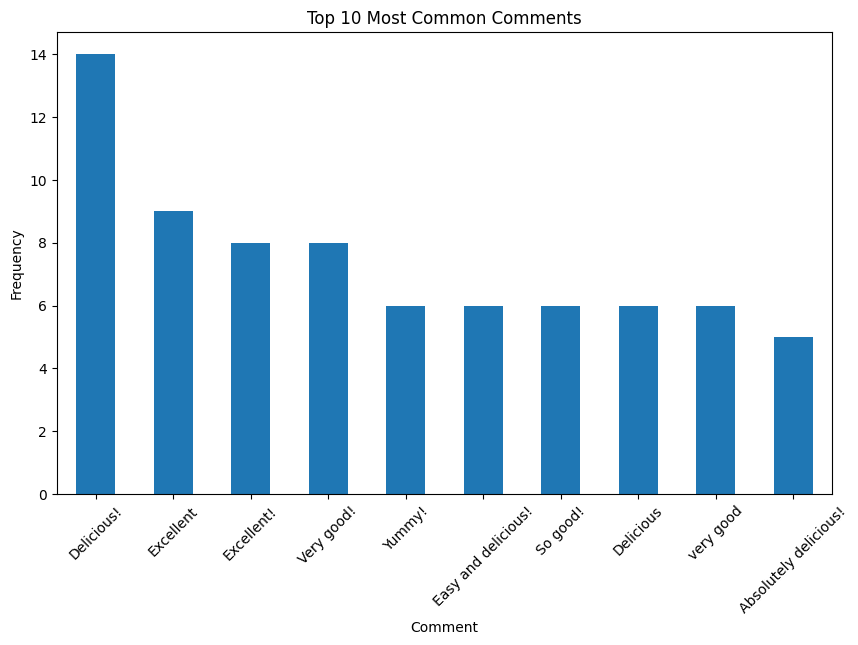

In [5]:
## Check for duplicate texts
text_counts = data['text'].value_counts()
top_duplicates = text_counts[text_counts > 1].head(10)
print("\nDuplicate comments (text) and their counts:")
for text, count in top_duplicates.items():
    print(f"{text}: {count} times")

## Identify long texts
def is_long_text(text, min_words=4):
    words = word_tokenize(text)
    return len(words) > min_words

long_texts = data_clean['text'][data_clean['text'].apply(is_long_text)]
long_text_counts = long_texts.value_counts()
top_long_duplicates = long_text_counts[long_text_counts > 1].head(10)

print("\nDuplicate long comments (more than 4 words) and their counts:")
for text, count in top_long_duplicates.items():
    print(f"{text}: {count} times")

## Identify repeated words in comments
def find_repeated_words(text):
    pattern = r'\b(\w+)(?:\s+\1\b)+'
    repeated_words = re.findall(pattern, text)
    return repeated_words

data_clean['repeated_words'] = data_clean['text'].apply(lambda x: find_repeated_words(x))
repeated_comments = data_clean[data_clean['repeated_words'].apply(len) > 0]
print("\nExamples of comments with repeated words:")
display(repeated_comments[['text', 'repeated_words']].head(10))

## Visualize the most common comments
top_comments = data['text'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_comments.plot(kind='bar')
plt.title('Top 10 Most Common Comments')
plt.xlabel('Comment')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [7]:
## Data Cleaning for LDA
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ''.join(char for char in text if unicodedata.category(char)[0] != 'C')
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['text'] = data['text'].apply(clean_text)
print("\nCleaned text examples:")
display(data['text'].head(10))

## LDA Model Training
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
count_data = count_vectorizer.fit_transform(data['text'])

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(count_data)

## Display the top words in each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 10
print("\nTop words per topic:")
display_topics(lda, count_vectorizer.get_feature_names_out(), num_top_words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Cleaned text examples:


0    tweaked little removed onion onion hater house...
1    bush used white chili bean made recipe super s...
2    complicated white chicken chili recipe made ye...
3    introduction mentioned cream cheese none liste...
4    wonderful made chilistew night dinner church e...
5         amazing boyfriend loved much going make week
6    wow recipe excellent written change made used ...
7    delicious make often one time daughter husband...
8    absolutely love recipe ive tweaked quite bit w...
9               make lot kid friend come ask make time
Name: text, dtype: object


Top words per topic:
Topic 0:
pepper recipe added bean chili add green used pumpkin red
Topic 1:
used chicken cream soup added recipe use cheese instead broth
Topic 2:
loved family recipe make pie hit husband amp delicious big
Topic 3:
time good make like cheese little really cut recipe minute
Topic 4:
sauce used added tomato cheese use ground recipe sausage instead
Topic 5:
make easy recipe good delicious love great soup family time
Topic 6:
recipe bread best banana time followed make ive exactly great
Topic 7:
pan used apple pie cake recipe make use time cream
Topic 8:
sugar cup recipe used sweet make good added brown butter
Topic 9:
recipe cake year love make family time ive favorite making


In [8]:
## Visualize the topics using pyLDAvis
# Prepare the data for pyLDAvis
pyLDAvis.enable_notebook()

def prepare_lda_vis(lda, count_data, count_vectorizer):
    doc_lengths = [len(doc.split()) for doc in data['text']]
    term_frequency = count_data.toarray().sum(axis=0)
    vocab = count_vectorizer.get_feature_names_out()
    topic_term_dists = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
    doc_topic_dists = lda.transform(count_data)

    data_vis = {
        'topic_term_dists': topic_term_dists,
        'doc_topic_dists': doc_topic_dists,
        'doc_lengths': doc_lengths,
        'vocab': vocab,
        'term_frequency': term_frequency
    }
    return pyLDAvis.prepare(**data_vis)

panel = prepare_lda_vis(lda, count_data, count_vectorizer)
pyLDAvis.display(panel)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
